# Data Analyzer

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
import pandas as pd

In [34]:
onet_df = pd.read_csv('oneThreadTime.csv')

In [35]:
onet_df.head()

,Algorithm,Matrix_Size,Layer_2_matmul_time,Total_fastmm_time,Total_time
0,dgemm,512,5204562.0,56020914.0,102602406.6
1,bini322,512,6254049.0,65692988.0,111722768.7
2,schonhage333,512,6552512.0,68468198.0,114879526.8
3,smirnov224,512,5707803.0,61161703.0,106553489.5
4,smirnov225,512,6086669.0,65499683.0,110828566.8


In [47]:
manyt_df = pd.read_csv('all_threads_time.csv')

In [48]:
manyt_df.head()

,Algorithm,Matrix_Size,Layer_2_matmul_time,Total_fastmm_time,Total_time
0,dgemm,512,4.127403e+06,6.297955e+07,48.312985
1,bini322,512,2.883892e+07,3.837866e+08,196.926699
2,schonhage333,512,2.913865e+07,4.820353e+08,239.686213
3,smirnov224,512,3.233846e+07,4.119913e+08,203.177126
4,smirnov225,512,2.734447e+07,4.145826e+08,209.891835


In [36]:
# fastest algorithm at each size
def fastest_algo(df):
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    rows = []
    for size in matrix_sizes: 
        time = df[df['Matrix_Size'] == size]['Total_fastmm_time'].min()
        algo = df[df['Total_fastmm_time'] == time]['Algorithm'].iloc[0]
        if algo == 'dgemm':
            dgemm_speed_up = 'N/A'
        else:
            dgemm_time = df[(df['Matrix_Size'] == size) & (df['Algorithm'] == 'dgemm')]['Total_fastmm_time'].iloc[0]
            dgemm_speed_up = dgemm_time/ time
            
        rows.append({'Size':size, 'Fastest Algorithm': algo, 'dgemm speed up':dgemm_speed_up})
    
    print(pd.DataFrame(rows))

In [37]:
# fastest one thread algorithms
fastest_algo(onet_df)

   Size Fastest Algorithm dgemm speed up
0   512             dgemm            N/A
1  1024        smirnov442       1.083664
2  2048        smirnov444       1.205450
3  4096        smirnov444       1.266563
4  8192        smirnov444       1.271525


In [49]:
# fastest all thread algorithms
fastest_algo(manyt_df)

   Size Fastest Algorithm dgemm speed up
0   512             dgemm            N/A
1  1024             dgemm            N/A
2  2048             dgemm            N/A
3  4096             dgemm            N/A
4  8192             dgemm            N/A


In [57]:
def parallel_speedup(one_thread_df, all_thread_df, algorithm):
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    one_thread_times = []
    all_thread_times = []
    
    for size in matrix_sizes:
        one_thread_time = one_thread_df[(one_thread_df['Matrix_Size'] == size) & (one_thread_df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0]
        all_thread_time = all_thread_df[(all_thread_df['Matrix_Size'] == size) & (all_thread_df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0]
        print(f'Size: {size},      Parallel speed up: {one_thread_time/all_thread_time}')
    
    
    

In [58]:
parallel_speedup(onet_df, manyt_df, 'dgemm')

Size: 512,      Parallel speed up: 0.8895096509232062
Size: 1024,      Parallel speed up: 1.7410018804430902
Size: 2048,      Parallel speed up: 2.98003881517668
Size: 4096,      Parallel speed up: 5.23123062708694
Size: 8192,      Parallel speed up: 6.059563108929665


In [59]:
parallel_speedup(onet_df, manyt_df, 'smirnov444')

Size: 512,      Parallel speed up: 0.14480046683170275
Size: 1024,      Parallel speed up: 0.5901708680087903
Size: 2048,      Parallel speed up: 1.2915158700486564
Size: 4096,      Parallel speed up: 2.2349725251354466
Size: 8192,      Parallel speed up: 3.28177899458163


In [60]:
parallel_speedup(onet_df, manyt_df, 'smirnov442')

Size: 512,      Parallel speed up: 0.22903728815197325
Size: 1024,      Parallel speed up: 0.7644607586797217
Size: 2048,      Parallel speed up: 1.775863251916115
Size: 4096,      Parallel speed up: 3.608243062125481
Size: 8192,      Parallel speed up: 4.799601541619025


In [44]:
def time_plotter(algorithm, df):
    dgemm_times = []
    algorithm_times = []
    
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    for size in matrix_sizes:
        dgemm_times.append(df[(df['Matrix_Size'] == size) & (df['Algorithm'] == 'dgemm')]['Total_fastmm_time'].iloc[0])
        algorithm_times.append(df[(df['Matrix_Size'] == size) & (df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0])
    

    x = np.arange(len(matrix_sizes))
    width = 0.2

    plt.rcParams['figure.figsize'] = [15, 6]

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, dgemm_times, width, label='dgemm')
    rects2 = ax.bar(x + width/2, algorithm_times, width, label=algorithm)

    ax.set_ylabel('Total FastMM time')
    ax.set_xlabel('Matrix size')
    ax.set_title(f'{algorithm} time vs dgemm time')
    ax.set_xticks(x)
    ax.set_xticklabels(matrix_sizes)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()


    plt.show()

## Fastest One Thread Algorithms vs dgemm (classic matmul)

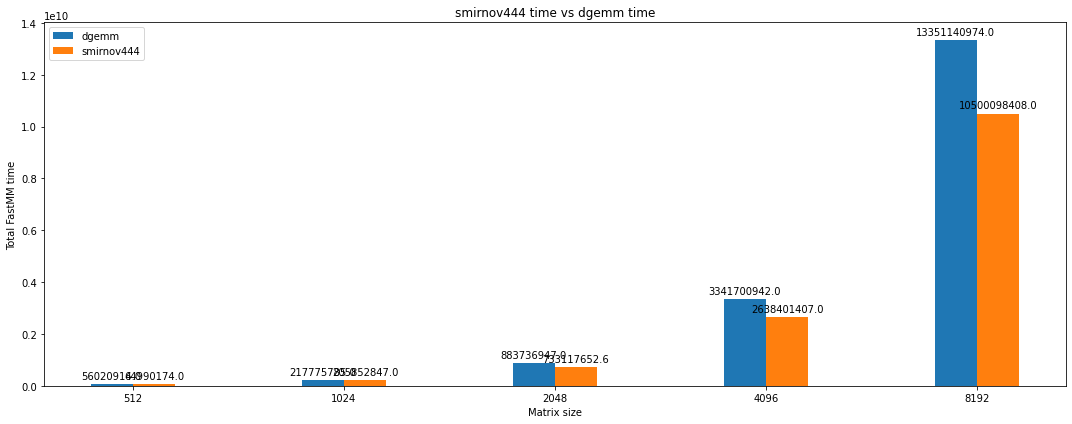

In [45]:
time_plotter(algorithm='smirnov444', df=onet_df)

The average epoch time goes down as the batch size gets larger because less multiplications are being done

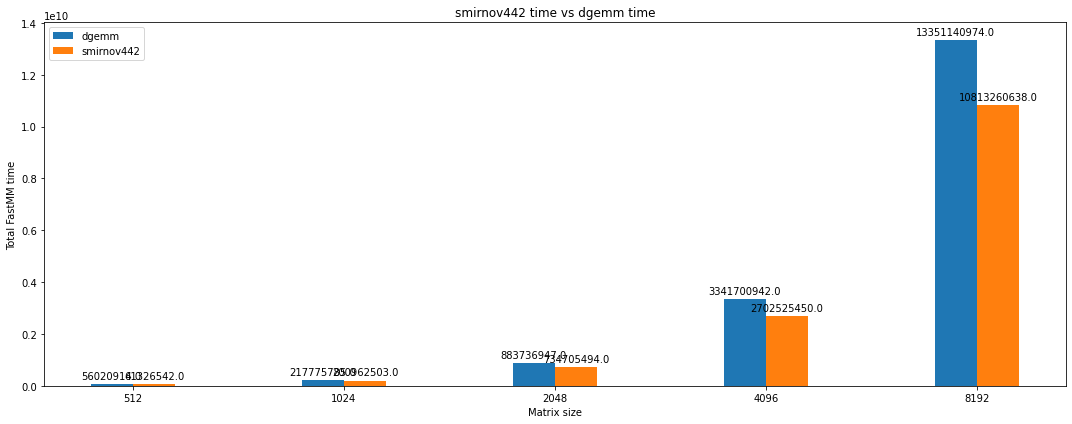

In [46]:
time_plotter(algorithm='smirnov442', df=onet_df)

## All Thread times

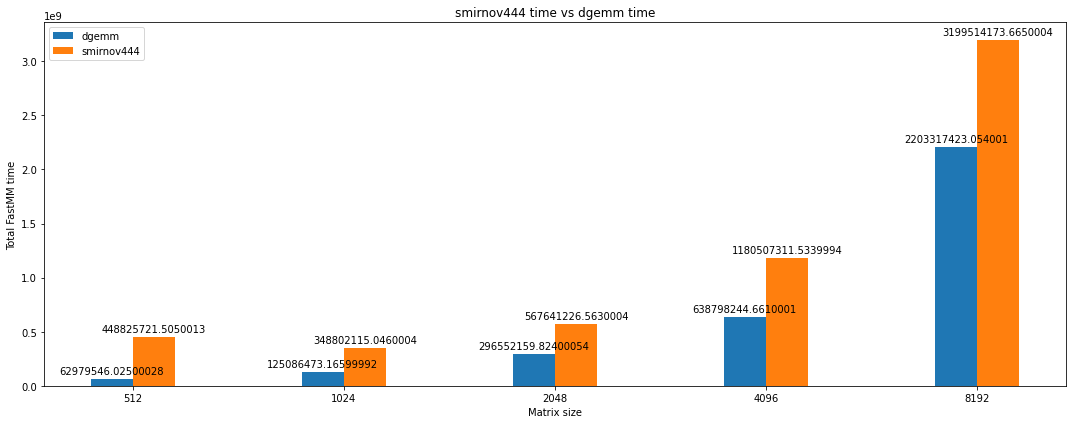

In [51]:
time_plotter(algorithm='smirnov444', df=manyt_df)

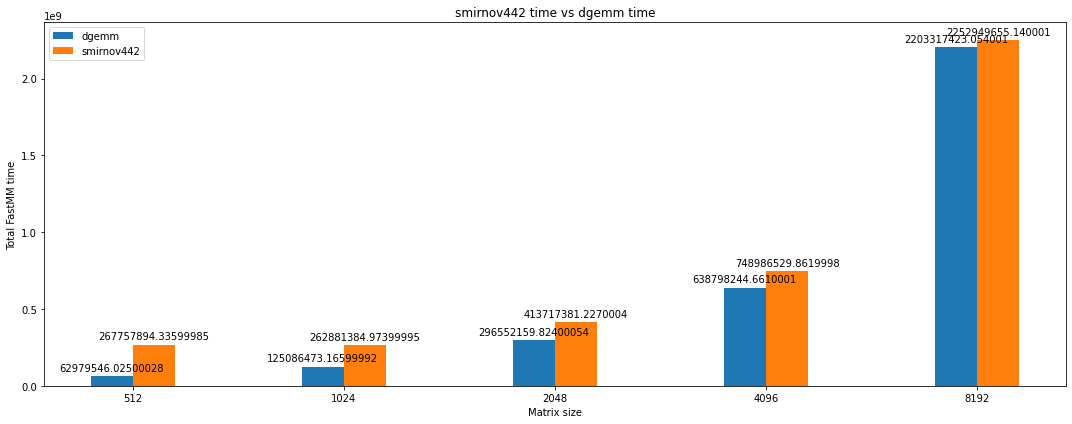

In [52]:
time_plotter(algorithm='smirnov442', df=manyt_df)